# Deep learning for medical imaging

==============================================================================================
## Practicum 2: Computed Tomography Image Reconstruction
==============================================================================================

In this practicum, you will (1) simulate a simple phantom slice image, (2) apply Radom forward transformation to simulate the computed tomography (CT) projections over an slice (i.e. sinograms) and (3) reconstruct the original phantom intensity values using different image reconstruction algorithms.  

### Aims:
- Understand the principles of CT image reconstruction using a fan beam geometry with the aid of ``skimage``.
- Be able to generate image projections (i.e. sinograms).
- Reconstruct slices from simple and more complex objects (i.e. Shepp–Logan phantom) using back projection and iterative methods.
- Analyse and compare reconstructed data with ground truth data.
- Observe the difference between ideal (noise free) and noisy image reconstruction.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon

### 2.1 Create a simple and homogeneous phantom (1.5 points)

Create a 2D simple phantom which contains a fake lesion as shown below:

<img src='images_4_notebook/SimplePhantom.png' width="200">

- Phantom size: 256 x 256 pixels.
- Phantom must contain 3 tissues:
    - Background = 0 pixel intensity value
    - Tissue 1 = 1 (radius = 100 pixels)
    - Tissue 2 (lesion) = 2 (radius = 5 pixels)
    
Help: To create the circunferences, you can use the function ``create_circular_mask``, or define your own function. The lesion could be located in any position within the phantom.

Once constructed, plot the original phantom and a pixel intensity (horizontal) profile along the lesion. Always remember to include the units of the axis when ploting a graph.

In [4]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
# https://newbedev.com/how-can-i-create-a-circular-mask-for-a-numpy-array

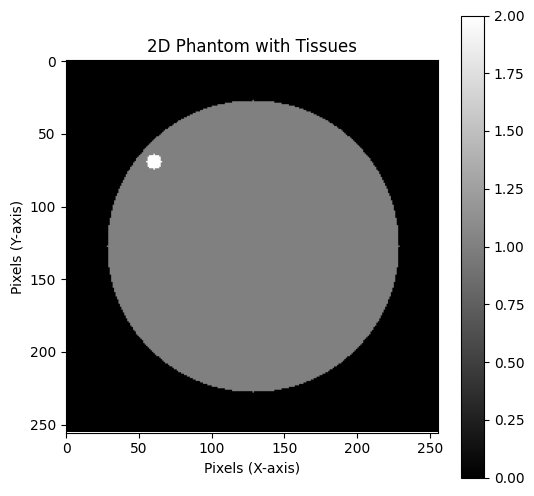

In [5]:
# insert your code here
# Phantom size and pixel intensity values
phantom_size = (256, 256)
background_value = 0
tissue1_value = 1
tissue2_value = 2

# Create masks for tissue 1 and tissue 2
tissue1_mask = create_circular_mask(phantom_size[0], phantom_size[1], radius=100)
tissue2_mask = create_circular_mask(phantom_size[0], phantom_size[1],center=(60,70), radius=5)

# Create the phantom by combining the masks
phantom = np.zeros(phantom_size)
phantom[tissue1_mask] = tissue1_value
phantom[tissue2_mask] = tissue2_value
plt.figure(figsize=(6, 6))
plt.imshow(phantom, cmap='gray')
plt.title("2D Phantom with Tissues")
plt.xlabel("Pixels (X-axis)")
plt.ylabel("Pixels (Y-axis)")
plt.colorbar()
plt.show()


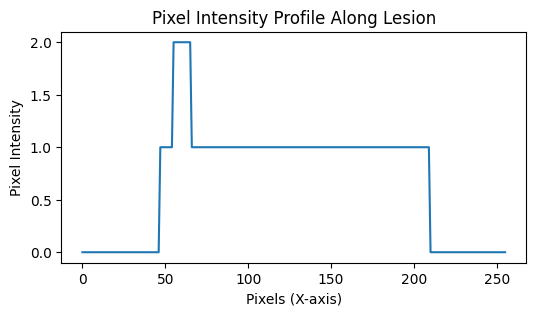

In [14]:
# Generate a pixel intensity profile along the lesion (horizontal)
lesion_profile = phantom[70, :]
plt.figure(figsize=(6, 3))
plt.plot(lesion_profile)
plt.title("Pixel Intensity Profile Along Lesion")
plt.xlabel("Pixels (X-axis)")
plt.ylabel("Pixel Intensity")
plt.show()


### 2.2 Create the projections of the phantom (2 points)

Generate the projections of the previously generated phantom using the ``radon`` transform from ``skimage.transform``. Play with the different parameters to optimise sinogram. Then, show the sinogram of the projections.

In this section, considered the following 2 approches:

``A``. Use different number of projections (i.e. 4, 20, 50, 100, 200, 300, 360) considering that in all cases the simulated projections cover the 360º. For example, 100 projections are taken in the range from 0º to 360º.

``B``. Use different ranges of angles (i.e. 4º, 20º, 50º, 100º, 200º, 300º, 360º) equally distributed.  For instance, 100 projections are taken in a range of 100º.

``Questions``: What is the effect of increasing/decrasing the number of proyections? Can you comment on the difference between approach A and B?

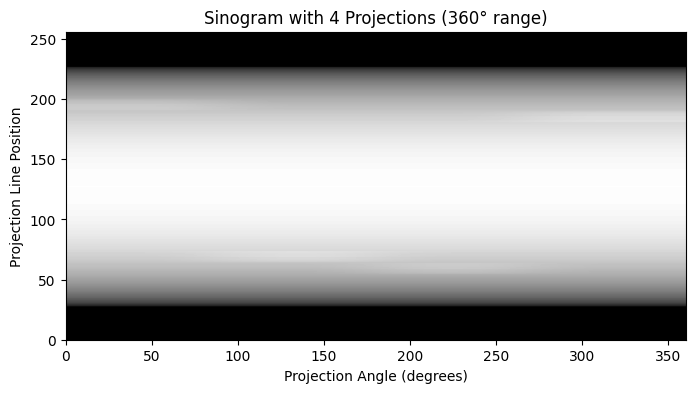

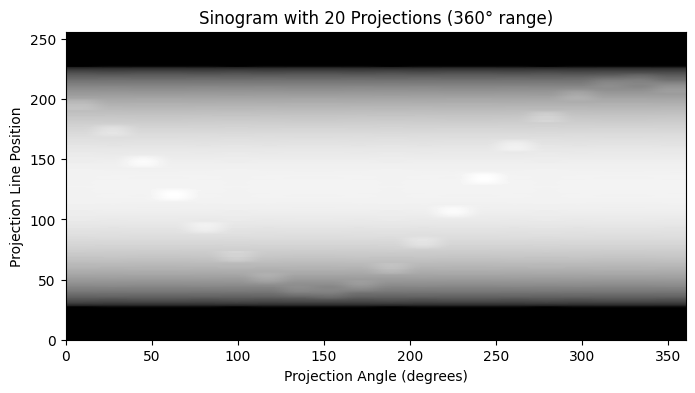

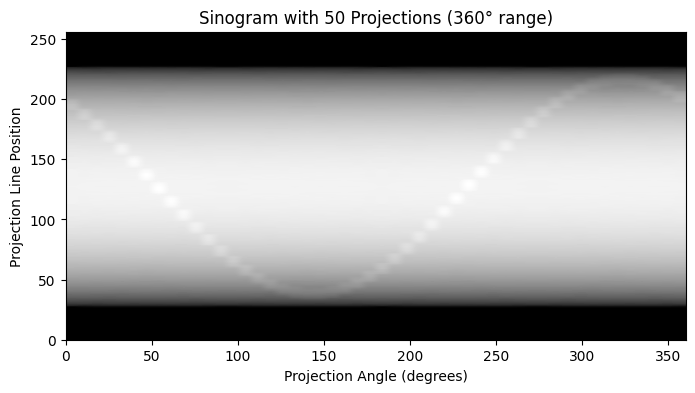

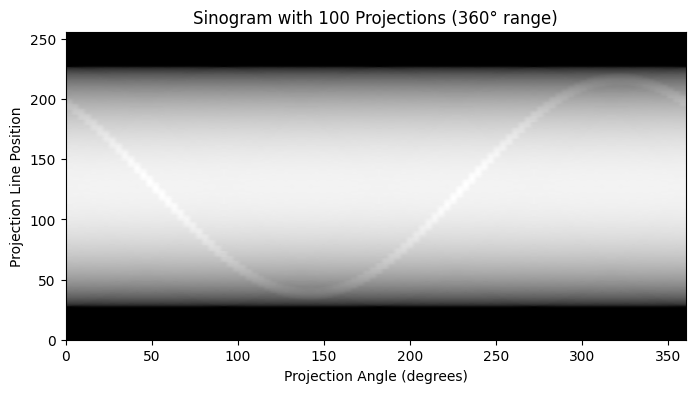

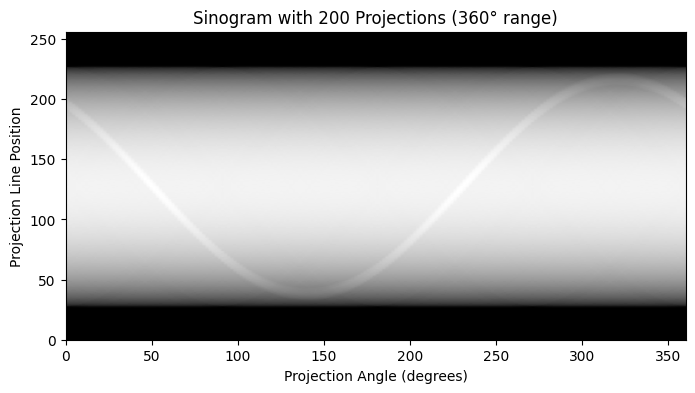

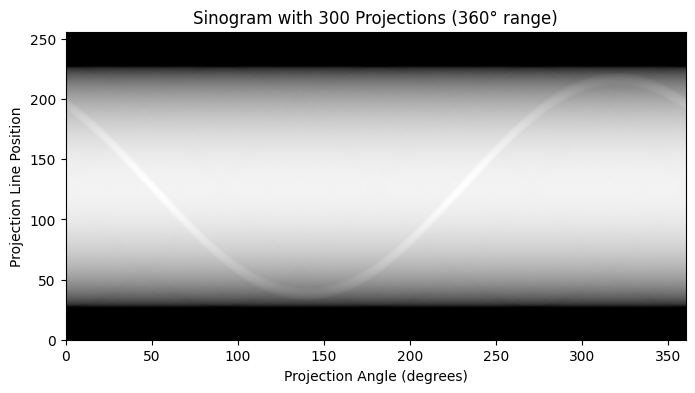

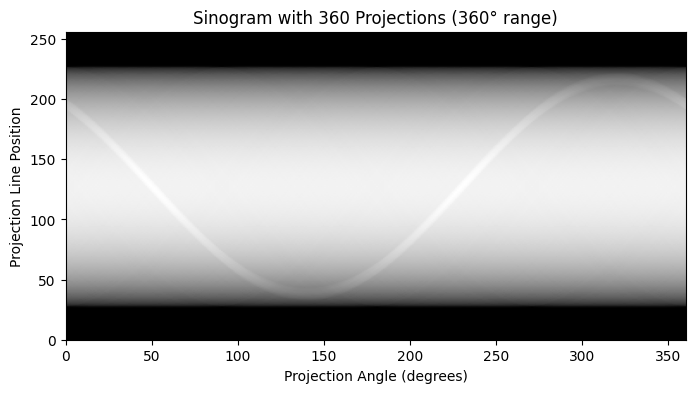

In [7]:
# insert your code here

def generate_and_plot_sinogram(image, num_projections, angle_range):
    sinogram = radon(image, theta=np.linspace(0, angle_range, num_projections, endpoint=False))
    plt.figure(figsize=(8, 4))
    plt.imshow(sinogram, cmap='gray', extent=(0, angle_range, 0, sinogram.shape[0]), aspect='auto')
    plt.title(f'Sinogram with {num_projections} Projections ({angle_range}° range)')
    plt.xlabel('Projection Angle (degrees)')
    plt.ylabel('Projection Line Position')
    plt.show()

# Approach A: Vary the number of projections (constant 360° coverage)
approach_a_projections = [4, 20, 50, 100, 200, 300, 360]
angle_range_a = 360  # Full 360° coverage

for num_projections in approach_a_projections:
    generate_and_plot_sinogram(phantom, num_projections, angle_range_a)

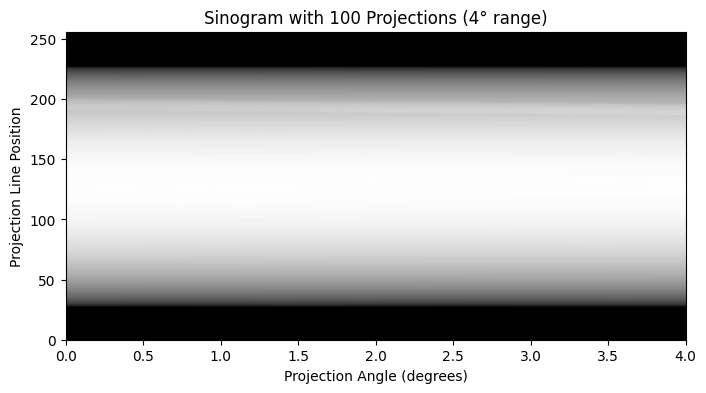

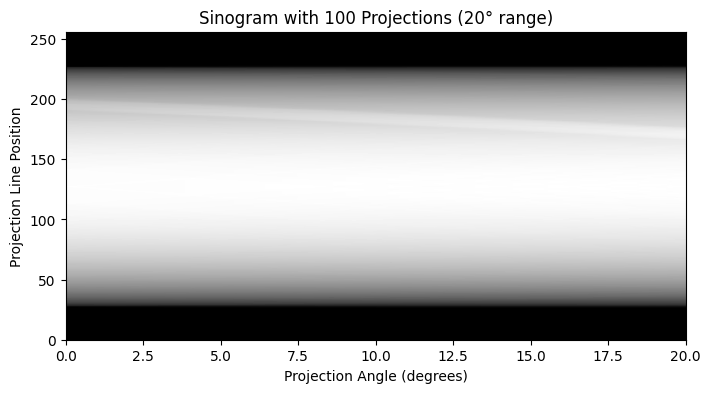

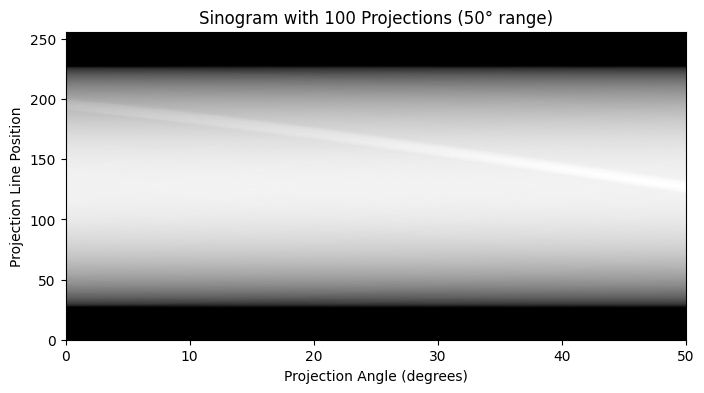

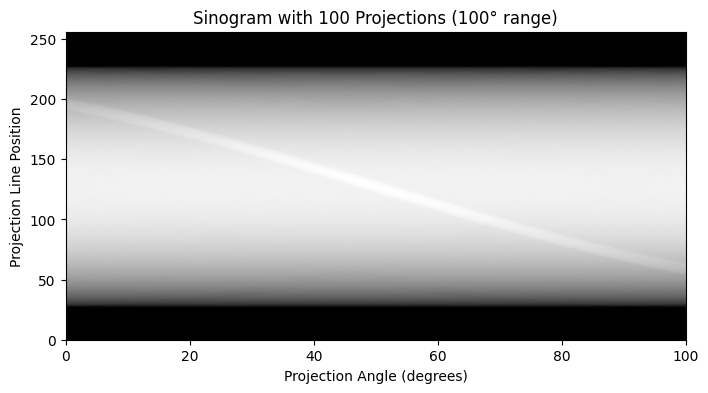

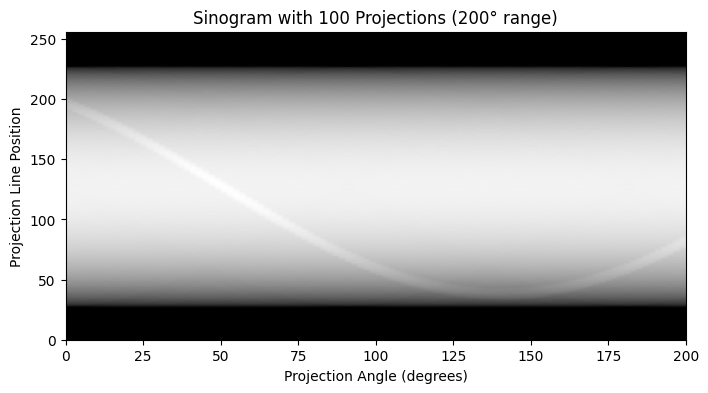

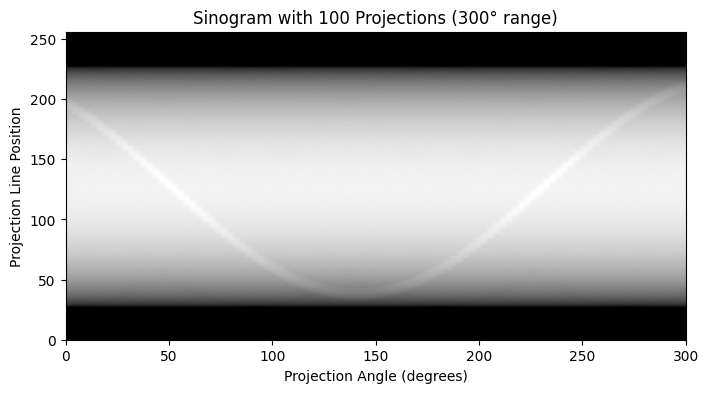

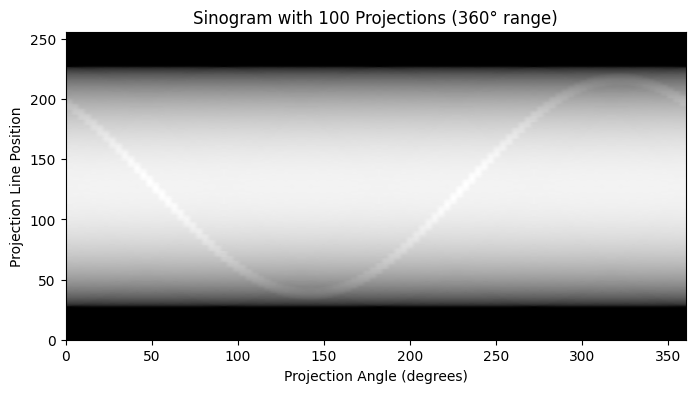

In [8]:
# Approach B: Vary the angle range (constant number of projections)
num_projections_b = 100  # Constant number of projections

angle_ranges_b = [4, 20, 50, 100, 200, 300, 360]

for angle_range in angle_ranges_b:
    generate_and_plot_sinogram(phantom, num_projections_b, angle_range)

Effect of Increasing/Decreasing the Number of Projections:

As the number of projections increases, the sinogram becomes smoother and contains more information about the object. This leads to better image reconstruction in the next steps (e.g., filtered back projection).
Fewer projections result in a sparser sinogram with less detail and may lead to artifacts in the reconstructed image.
Approach A vs. B:
Approach A changes the number of projections while keeping a full 360° coverage. It mainly affects the granularity of the information in the sinogram.
Approach B changes the angle range while keeping the number of projections constant. It influences the angular coverage of the projections, affecting the visibility of different features in the sinogram.


### 2.3 Reconstruction with Filtered Back Projection (FBP) (2.5 points)

FBP is one of the most simple reconstruction methods to reconstruct images in CT. Explore the ``iradon`` from ``skimage.transform`` using the different filters available (Ramp filter (default), Shepp-logan, Cosine, Hamming, Hann).

Then, show the original and reconstructed images of the phantom.

Explore the two approches (A and B) described previously.

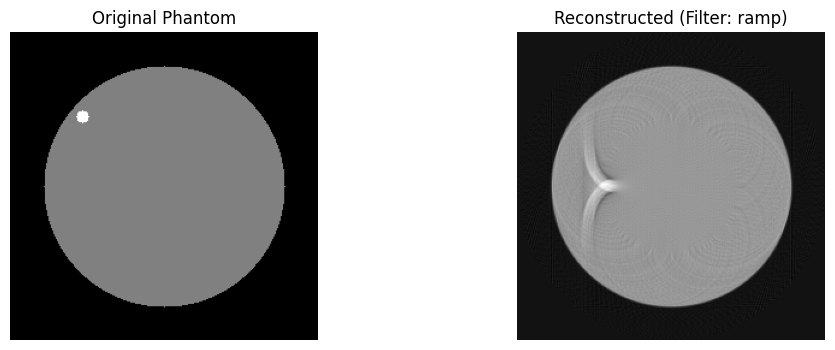

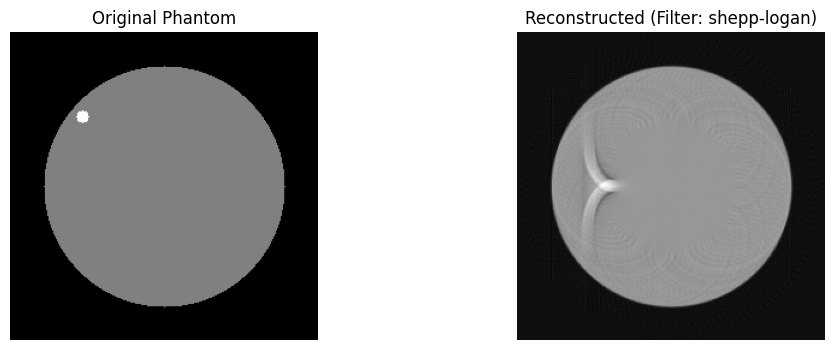

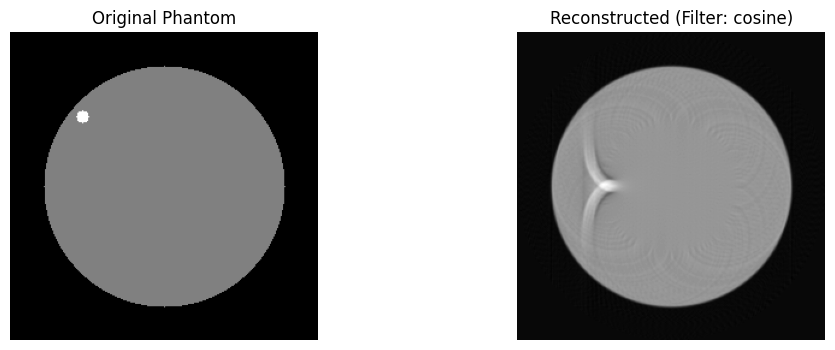

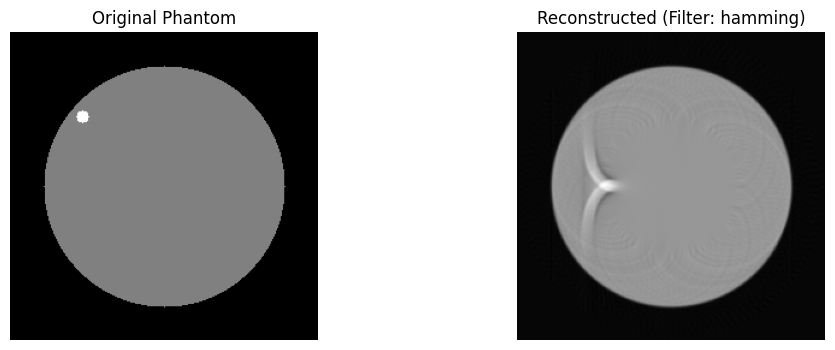

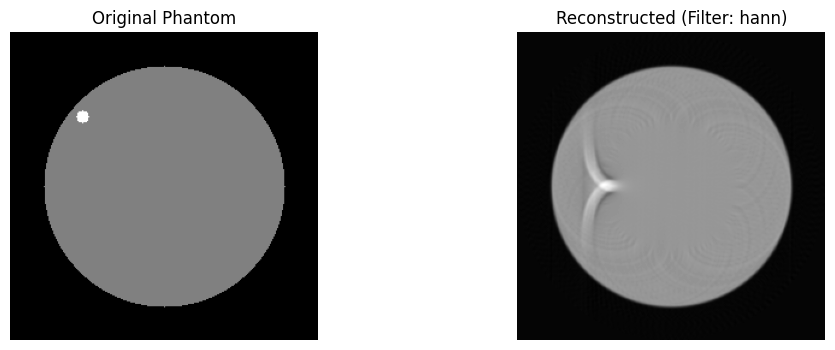

In [6]:
# insert your code here
from skimage.transform import iradon
# Function to reconstruct the image using FBP with different filters
def reconstruct_image(sinogram, filter_name):
    reconstructed_image = iradon(sinogram, filter_name=filter_name)
    return reconstructed_image

# Create sinograms for both approaches
def create_sinogram(image, num_projections, angle_range):
    sinogram = radon(image, theta=np.linspace(0, angle_range, num_projections, endpoint=False))
    return sinogram

# Filters to explore
filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

# Approach A: Vary the number of projections (constant 360° coverage)
num_projections_a = 100 # Constant number of projections
angle_range_a = 100
sinogram = create_sinogram(phantom, num_projections_a, angle_range_a)

for filter_name in filters:
    reconstructed_image_a = reconstruct_image(sinogram, filter_name)

    # Plot original and reconstructed images for Approach A
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(phantom, cmap='gray')
    plt.title("Original Phantom")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image_a, cmap='gray')
    plt.title(f"Reconstructed (Filter: {filter_name})")
    plt.axis('off')
    plt.show()


With approach A  lession was visible even with 100 projections but to get the same image we needed to change the angle range to 180°. Filters did not change the image much.

### 2.4 Compare the reconstructed signals (1 points)

Make use of the ``matplotlib`` to compare the original and reconstructed signals. In order to do so, make a single plot with the different pixel intensity profiles of the lesion or provide any other evaluation metric you could consider useful for this purpose (image difference, root mean square error, etc.). Then, discuss the results.

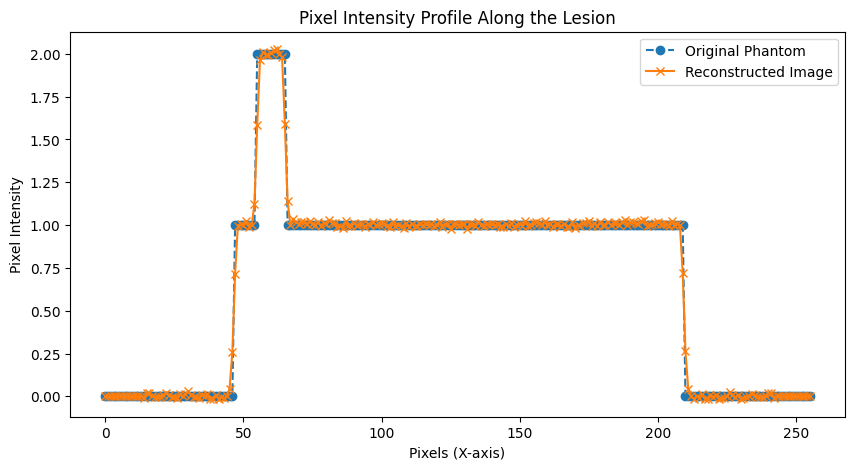

In [8]:
# insert your code here
sinogram= create_sinogram(phantom, 200, 180)
# Reconstruct the image with a filter
reconstructed_image = iradon(sinogram, filter_name='ramp')

# Pixel intensity profile along the lesion in the original phantom
original_profile = phantom[70, :]

# Pixel intensity profile along the lesion in the reconstructed image
reconstructed_profile = reconstructed_image[70, :]

# Plot pixel intensity profiles
plt.figure(figsize=(10, 5))
plt.plot(original_profile, label='Original Phantom', linestyle='--', marker='o')
plt.plot(reconstructed_profile, label='Reconstructed Image', linestyle='-', marker='x')
plt.title('Pixel Intensity Profile Along the Lesion')
plt.xlabel('Pixels (X-axis)')
plt.ylabel('Pixel Intensity')
plt.legend()
plt.show()

The reconstructed image is not as smooth as the original image. This is due to the fact that the sinogram is not as smooth as the original image. The sinogram is not as smooth as the original image because we are using a small number of projections (100) when using more projecttions the line becomes much more smooth.

### 2.5 Reconstructing noisy sinograms (2 points)

Add Poison noise (``np.random.poisson``; perhaps with lam = 10) to your previous sinograms (not to the image!) and reconstruct the phantom images with the different filters. Plot the reconstruction image and the (vertical or horizontal) intensity profile along the lession or use any other method you can considered, as described in the prior section. Then, comment on the effects of the filters on the reconstructed phatom images.

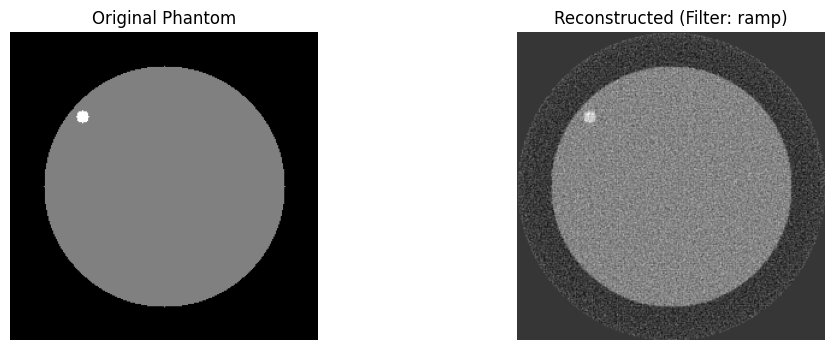

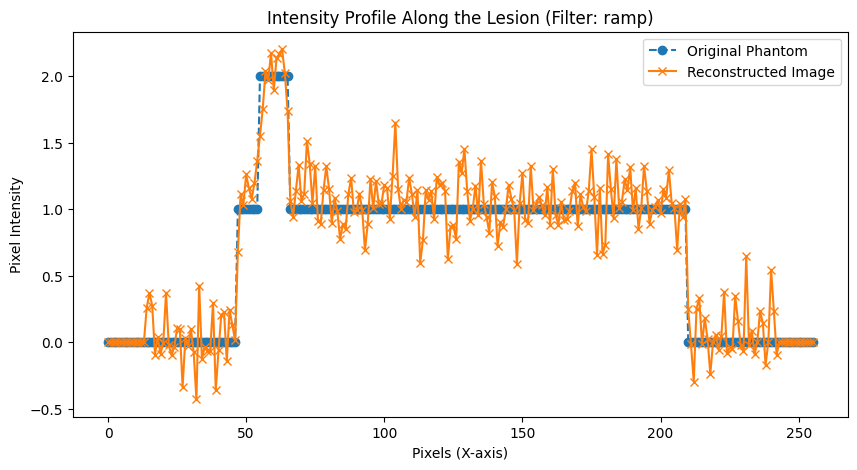

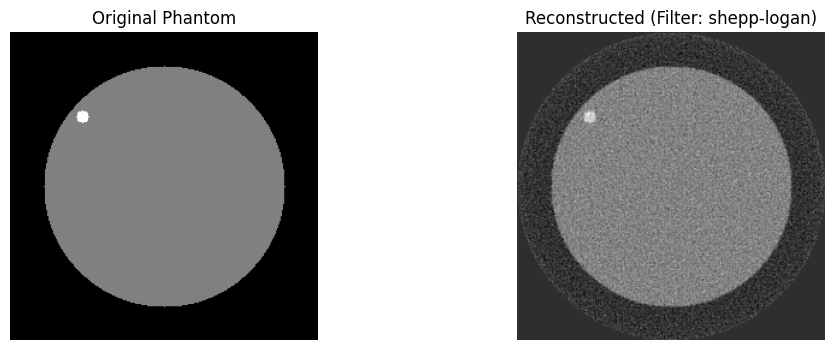

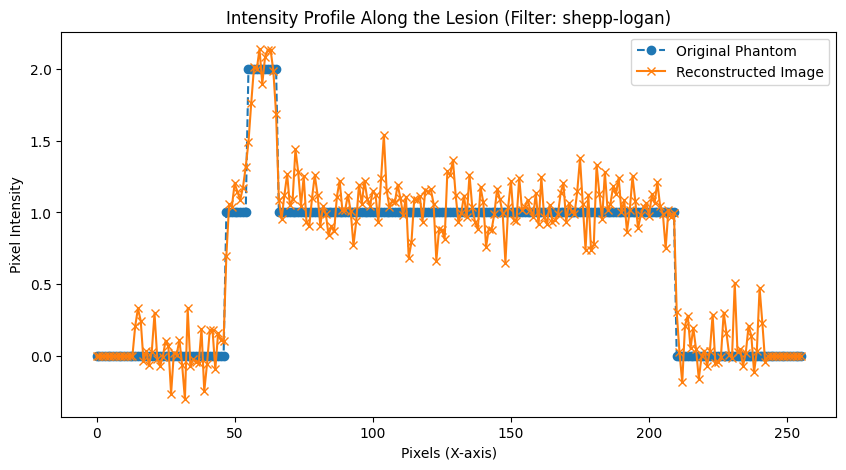

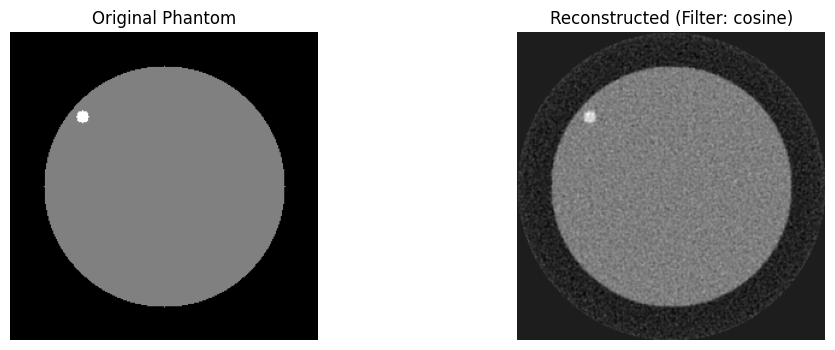

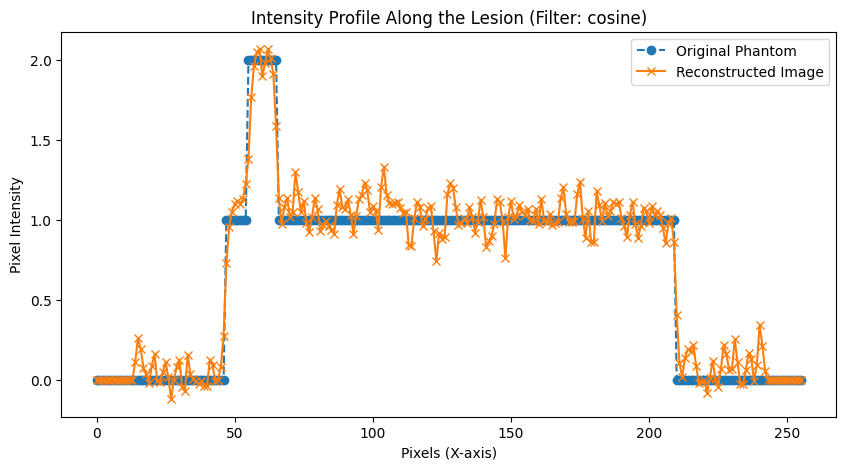

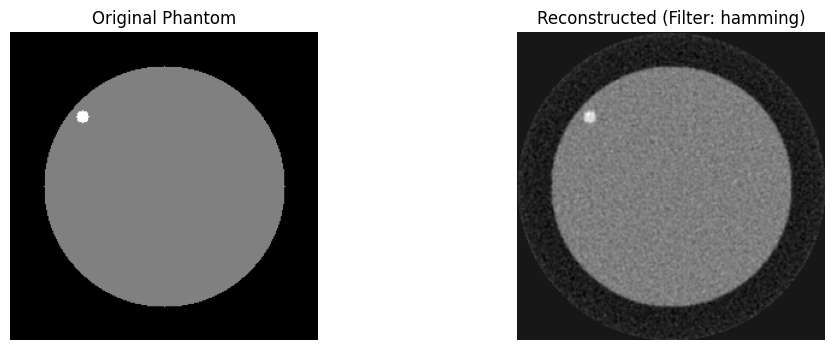

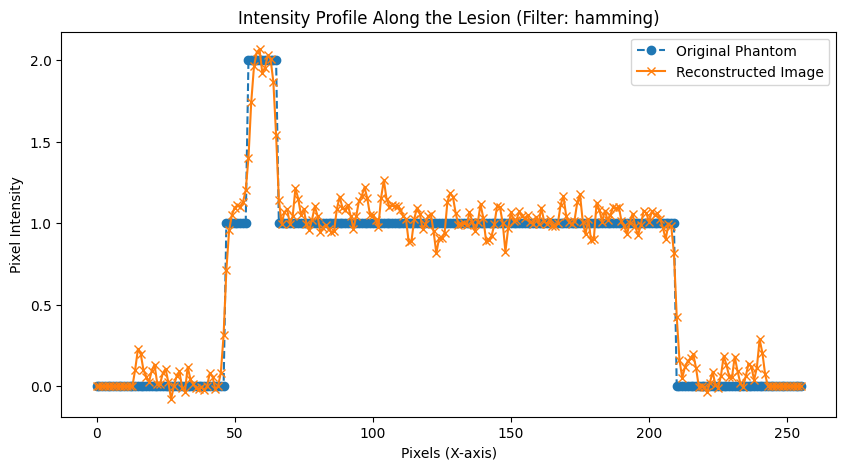

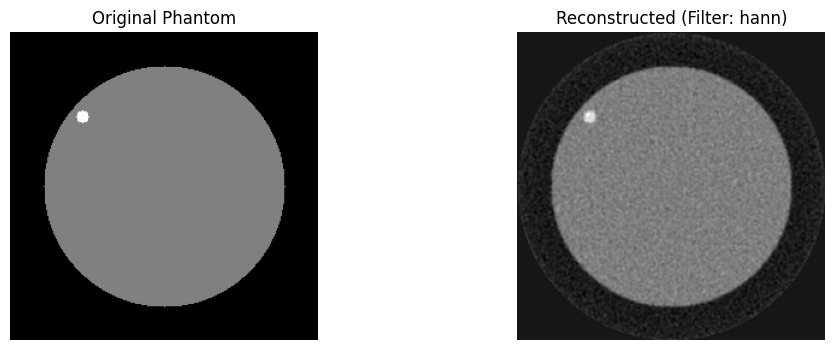

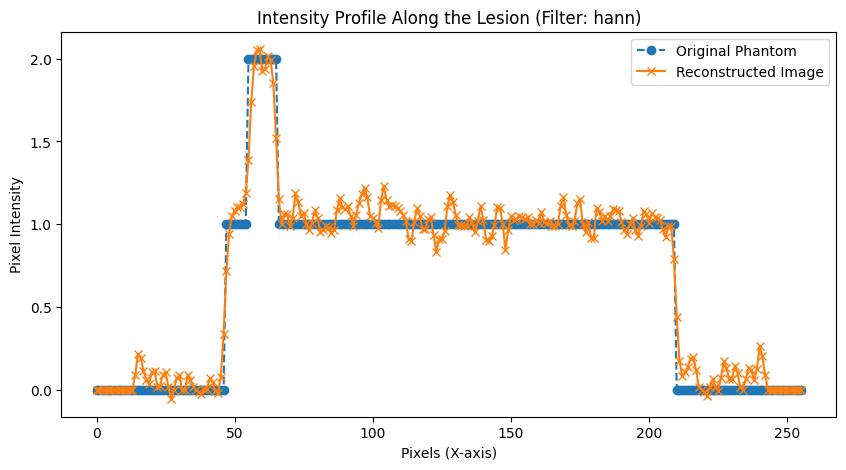

In [23]:
sinogram= create_sinogram(phantom, 100, 180)
# insert your code here
sinogram_with_noise = np.random.poisson(lam=10,size=sinogram.shape) + sinogram
# Plot and compare reconstruction with different filters
for filter_name in filters:
    # Reconstruct the image with the selected filter
    reconstructed_image = reconstruct_image(sinogram_with_noise, filter_name)

    # Plot the original and reconstructed images for comparison
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(phantom, cmap='gray')
    plt.title("Original Phantom")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f"Reconstructed (Filter: {filter_name})")
    plt.axis('off')
    plt.show()

    # Plot pixel intensity profiles along the lesion
    lesion_profile_original = phantom[70, :]
    lesion_profile_reconstructed = reconstructed_image[70, :]

    plt.figure(figsize=(10, 5))
    plt.plot(lesion_profile_original, label='Original Phantom', linestyle='--', marker='o')
    plt.plot(lesion_profile_reconstructed, label='Reconstructed Image', linestyle='-', marker='x')
    plt.title(f'Intensity Profile Along the Lesion (Filter: {filter_name})')
    plt.xlabel('Pixels (X-axis)')
    plt.ylabel('Pixel Intensity')
    plt.legend()
    plt.show()


We can see the filters really changed the  intesinty profile and lines is much more rough then in previous images.

### 2.6 Sheep logan phantom (1 point)

So far we have used a quite simple phantom with only 2 tissues. Now, repeat the prior analysis for the **noisy sinogram** for one case (approach, filter,...) using a (slightly) more advanced head test object, the Sheep-logan phantom. Do you observe particular differences between the reconstrucction results from both phantoms? 


In [6]:
from skimage.data import shepp_logan_phantom

image = shepp_logan_phantom()

# insert your code here

### 2.7 Deep learning challenge (optional)
If you like this topic and want to explore deep learning (DL) approaches for CT image reconstruction, I encourage you to look at this **ICASSP-2024 3D-CBCT challenge** to advance the frontiers of DL for low-dose 3D cone-beam CT reconstruction at https://sites.google.com/view/icassp2024-spgc-3dcbct